In [1]:
import matplotlib.pyplot as plt
import numpy as np
import platform
import os
import imblearn
from sklearn.utils import class_weight

%matplotlib inline
%load_ext autoreload
%aimport utils
%autoreload 1

Using TensorFlow backend.


In [2]:
### CACHE FILENAMES ###

train_normal_cache = "training_normal.pickle"
train_pneumonia_cache = "training_pneumonia.pickle"
val_normal_cache = "validation_normal.pickle"
val_pneumonia_cache = "validation_pneumonia.pickle"
test_normal_cache = "testing_normal.pickle"
test_pneumonia_cache = "testing_pneumonia.pickle"

### DATA SETTINGS ###

pdiv = "/" if platform.system() == "Windows" else "\\"

path_train_normal = ".{}chest_xray{}train{}NORMAL{}".format(pdiv, pdiv, pdiv, pdiv)
path_train_pneumonia = ".{}chest_xray{}train{}PNEUMONIA{}".format(pdiv, pdiv, pdiv, pdiv)
path_val_normal = ".{}chest_xray{}val{}NORMAL{}".format(pdiv, pdiv, pdiv, pdiv)
path_val_pneumonia = ".{}chest_xray{}val{}PNEUMONIA{}".format(pdiv, pdiv, pdiv, pdiv)
path_test_normal = ".{}chest_xray{}test{}NORMAL{}".format(pdiv, pdiv, pdiv, pdiv)
path_test_pneumonia = ".{}chest_xray{}test{}PNEUMONIA{}".format(pdiv, pdiv, pdiv, pdiv)

### MODELS PATH ###

path_models = ".{}CNNModels{}".format(pdiv, pdiv)

### LABELS ###

normal_label = 0
pneumonia_label = 1
labels = sorted([normal_label, pneumonia_label])

### IMAGE SETTINGS ###

dimension = (64, 64, 3)
resize_dim = dimension[:2]

In [3]:
### LOAD TRAINING DATA AND LABELS ###

data_train_normal, label_train_normal = utils.load_data(path_train_normal, train_normal_cache, normal_label)
data_train_pneumonia, label_train_pneumonia = utils.load_data(path_train_pneumonia, train_pneumonia_cache, pneumonia_label)

# Caching, disabled for now
# utils.cache(data_train_normal, train_normal_cache)
# utils.cache(data_train_pneumonia, train_pneumonia_cache)

# Combine training images and labels
data_train = np.concatenate((data_train_normal, data_train_pneumonia), axis=0)
label_train = np.asarray(label_train_normal + label_train_pneumonia)

# Shuffle
rand_order = np.random.permutation(data_train.shape[0])
data_train = data_train[rand_order]
label_train = label_train[rand_order]

del data_train_normal
del data_train_pneumonia

Cache not found, loading images..
Cache not found, loading images..


In [4]:
### IMAGE PROCESSING ###

# Image cropping
data_train = utils.images_crop_from_centre(data_train, percentage=0.9)

# Image resizing
data_train = utils.images_resize(data_train, resize_dim) 

# Image normalisation
data_train = utils.images_normalize(data_train)

In [5]:
### HANDLE IMBALANCED DATA ###
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE, BorderlineSMOTE

# Transform the dataset
# oversample = SMOTE(sampling_strategy='auto', k_neighbors=8, random_state=100)
# oversample = KMeansSMOTE(sampling_strategy='auto', k_neighbors=8, random_state=100)
# oversample = RandomOverSampler(random_state=42)
oversample = BorderlineSMOTE(random_state=100)
data_train, label_train = oversample.fit_resample(data_train.reshape(data_train.shape[0], -1), label_train)
data_train = data_train.reshape(data_train.shape[0], dimension[0], dimension[1], dimension[2])

# Shuffle
rand_order = np.random.permutation(data_train.shape[0])
data_train = data_train[rand_order]
label_train = label_train[rand_order]

In [6]:
class_weights = class_weight.compute_class_weight('balanced', np.asarray(labels), label_train)
class_weights = dict(enumerate(class_weights))

In [7]:
### MODEL PARAMETERS ###
loss_func = "mean_squared_error"
epochs_num = 10000
model_name = "mutliCNN_smote"
checkpoint_name = "_best_overall"
intermediary_name = model_name + checkpoint_name
ext = ".hdf5"

In [8]:
### LOAD ALL MODELS ###
from keras.models import load_model

models = []
(_, _, model_names) = next(os.walk(path_models))
for name in model_names:
    models.append(load_model(path_models + name))
    print("Successfully loaded {}".format(path_models + name))

Successfully loaded ./CNNModels/dense121_smote_71.hdf5
Successfully loaded ./CNNModels/dense169_smote_79.hdf5
Successfully loaded ./CNNModels/dense201_smote_80.hdf5
Successfully loaded ./CNNModels/resnet101v2_smote_79.hdf5
Successfully loaded ./CNNModels/resnet152v2_smote_75.hdf5
Successfully loaded ./CNNModels/resnet50v2_smote_79.hdf5
Successfully loaded ./CNNModels/vgg16_smote_82.hdf5
Successfully loaded ./CNNModels/vgg19_smote_82.hdf5


In [9]:
### GET OUTPUT OF EACH MODEL ###
compiled_output_train = np.asarray(list(map(lambda model: model.predict(data_train, verbose=1), models))).T
compiled_output_train = compiled_output_train.reshape((data_train.shape[0], len(models), 1))

7750/7750 [==============================] - 284s 37ms/step


In [10]:
### MODEL CREATION ###
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.utils import print_summary
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_input = Input(shape=(len(models), 1))
# model = Dense(units=12, activation='relu')(model_input)
# model = Flatten(model)
model = Dense(units=8, activation='relu')(model_input)
model = Flatten()(model)
preds = Dense(units=1, activation='sigmoid')(model)
model = Model(inputs=model_input, outputs=preds)

# Set trainable layers
for layer in model.layers:
    layer.trainable = True

# Callbacks
# es_val_loss = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# es_val_acc = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)
checkpointer = ModelCheckpoint(intermediary_name + ext, verbose=1, save_best_only=True)
# callbacks_list = [es_val_loss, es_val_acc, checkpointer]
callbacks_list = [checkpointer]

# Define optimiser, loss function, and metrics to track
opt = SGD(lr=0.01)
model.compile(optimizer=opt, loss=loss_func, metrics=['accuracy'])

print("Total number of layers is {}".format(len(model.layers)))
print_summary(model)

Total number of layers is 4
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 1)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 8)              16        
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model training
history = model.fit(compiled_output_train, label_train, epochs=1000, validation_split=0.1, callbacks=callbacks_list, verbose=1)

Train on 6975 samples, validate on 775 samples
Epoch 1/1000
6975/6975 [==============================] - 0s 32us/step - loss: 0.2060 - accuracy: 0.6404 - val_loss: 0.1924 - val_accuracy: 0.6761

Epoch 00001: val_loss improved from inf to 0.19235, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 2/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.1762 - accuracy: 0.7368 - val_loss: 0.1669 - val_accuracy: 0.7742

Epoch 00002: val_loss improved from 0.19235 to 0.16687, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 3/1000
6975/6975 [==============================] - 0s 28us/step - loss: 0.1527 - accuracy: 0.8173 - val_loss: 0.1452 - val_accuracy: 0.8529

Epoch 00003: val_loss improved from 0.16687 to 0.14518, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 4/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.1328 - accuracy: 0.8899 - val_loss: 0.1265 - val_accuracy: 0.9213

Epoch 00004: val_loss improved from 0.14518 to 0.1

6975/6975 [==============================] - 0s 29us/step - loss: 0.0229 - accuracy: 0.9806 - val_loss: 0.0216 - val_accuracy: 0.9819

Epoch 00033: val_loss improved from 0.02204 to 0.02164, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 34/1000
6975/6975 [==============================] - 0s 32us/step - loss: 0.0225 - accuracy: 0.9806 - val_loss: 0.0213 - val_accuracy: 0.9819

Epoch 00034: val_loss improved from 0.02164 to 0.02127, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 35/1000
6975/6975 [==============================] - 0s 33us/step - loss: 0.0222 - accuracy: 0.9806 - val_loss: 0.0209 - val_accuracy: 0.9819

Epoch 00035: val_loss improved from 0.02127 to 0.02093, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 36/1000
6975/6975 [==============================] - 0s 33us/step - loss: 0.0219 - accuracy: 0.9811 - val_loss: 0.0206 - val_accuracy: 0.9819

Epoch 00036: val_loss improved from 0.02093 to 0.02061, saving model to mutliCNN_smote_best_overall.hdf

6975/6975 [==============================] - 0s 31us/step - loss: 0.0180 - accuracy: 0.9811 - val_loss: 0.0164 - val_accuracy: 0.9806

Epoch 00065: val_loss improved from 0.01647 to 0.01639, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 66/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0179 - accuracy: 0.9811 - val_loss: 0.0163 - val_accuracy: 0.9806

Epoch 00066: val_loss improved from 0.01639 to 0.01633, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 67/1000
6975/6975 [==============================] - 0s 31us/step - loss: 0.0179 - accuracy: 0.9812 - val_loss: 0.0163 - val_accuracy: 0.9806

Epoch 00067: val_loss improved from 0.01633 to 0.01626, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 68/1000
6975/6975 [==============================] - 0s 34us/step - loss: 0.0178 - accuracy: 0.9809 - val_loss: 0.0162 - val_accuracy: 0.9806

Epoch 00068: val_loss improved from 0.01626 to 0.01620, saving model to mutliCNN_smote_best_overall.hdf

6975/6975 [==============================] - 0s 31us/step - loss: 0.0168 - accuracy: 0.9814 - val_loss: 0.0150 - val_accuracy: 0.9806

Epoch 00097: val_loss improved from 0.01503 to 0.01500, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 98/1000
6975/6975 [==============================] - 0s 32us/step - loss: 0.0168 - accuracy: 0.9812 - val_loss: 0.0150 - val_accuracy: 0.9806

Epoch 00098: val_loss improved from 0.01500 to 0.01497, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 99/1000
6975/6975 [==============================] - 0s 31us/step - loss: 0.0167 - accuracy: 0.9812 - val_loss: 0.0149 - val_accuracy: 0.9806

Epoch 00099: val_loss improved from 0.01497 to 0.01494, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 100/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0167 - accuracy: 0.9812 - val_loss: 0.0149 - val_accuracy: 0.9819

Epoch 00100: val_loss improved from 0.01494 to 0.01492, saving model to mutliCNN_smote_best_overall.hd

6975/6975 [==============================] - 0s 27us/step - loss: 0.0162 - accuracy: 0.9814 - val_loss: 0.0143 - val_accuracy: 0.9819

Epoch 00129: val_loss improved from 0.01432 to 0.01430, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 130/1000
6975/6975 [==============================] - 0s 29us/step - loss: 0.0162 - accuracy: 0.9815 - val_loss: 0.0143 - val_accuracy: 0.9819

Epoch 00130: val_loss improved from 0.01430 to 0.01429, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 131/1000
6975/6975 [==============================] - 0s 26us/step - loss: 0.0162 - accuracy: 0.9815 - val_loss: 0.0143 - val_accuracy: 0.9819

Epoch 00131: val_loss improved from 0.01429 to 0.01427, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 132/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0162 - accuracy: 0.9815 - val_loss: 0.0143 - val_accuracy: 0.9819

Epoch 00132: val_loss improved from 0.01427 to 0.01425, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 38us/step - loss: 0.0159 - accuracy: 0.9812 - val_loss: 0.0138 - val_accuracy: 0.9819

Epoch 00161: val_loss improved from 0.01385 to 0.01384, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 162/1000
6975/6975 [==============================] - 0s 35us/step - loss: 0.0159 - accuracy: 0.9814 - val_loss: 0.0138 - val_accuracy: 0.9819

Epoch 00162: val_loss improved from 0.01384 to 0.01383, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 163/1000
6975/6975 [==============================] - 0s 38us/step - loss: 0.0159 - accuracy: 0.9814 - val_loss: 0.0138 - val_accuracy: 0.9819

Epoch 00163: val_loss improved from 0.01383 to 0.01382, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 164/1000
6975/6975 [==============================] - 0s 32us/step - loss: 0.0159 - accuracy: 0.9812 - val_loss: 0.0138 - val_accuracy: 0.9819

Epoch 00164: val_loss improved from 0.01382 to 0.01381, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 31us/step - loss: 0.0157 - accuracy: 0.9811 - val_loss: 0.0135 - val_accuracy: 0.9832

Epoch 00193: val_loss improved from 0.01351 to 0.01350, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 194/1000
6975/6975 [==============================] - 0s 29us/step - loss: 0.0157 - accuracy: 0.9812 - val_loss: 0.0135 - val_accuracy: 0.9832

Epoch 00194: val_loss improved from 0.01350 to 0.01349, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 195/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0157 - accuracy: 0.9812 - val_loss: 0.0135 - val_accuracy: 0.9832

Epoch 00195: val_loss improved from 0.01349 to 0.01348, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 196/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0157 - accuracy: 0.9811 - val_loss: 0.0135 - val_accuracy: 0.9832

Epoch 00196: val_loss improved from 0.01348 to 0.01347, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 34us/step - loss: 0.0155 - accuracy: 0.9812 - val_loss: 0.0132 - val_accuracy: 0.9832

Epoch 00225: val_loss improved from 0.01323 to 0.01322, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 226/1000
6975/6975 [==============================] - 0s 34us/step - loss: 0.0155 - accuracy: 0.9812 - val_loss: 0.0132 - val_accuracy: 0.9832

Epoch 00226: val_loss improved from 0.01322 to 0.01321, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 227/1000
6975/6975 [==============================] - 0s 35us/step - loss: 0.0155 - accuracy: 0.9814 - val_loss: 0.0132 - val_accuracy: 0.9832

Epoch 00227: val_loss improved from 0.01321 to 0.01321, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 228/1000
6975/6975 [==============================] - 0s 34us/step - loss: 0.0155 - accuracy: 0.9812 - val_loss: 0.0132 - val_accuracy: 0.9832

Epoch 00228: val_loss improved from 0.01321 to 0.01320, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 25us/step - loss: 0.0154 - accuracy: 0.9812 - val_loss: 0.0130 - val_accuracy: 0.9832

Epoch 00257: val_loss improved from 0.01300 to 0.01300, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 258/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0154 - accuracy: 0.9812 - val_loss: 0.0130 - val_accuracy: 0.9832

Epoch 00258: val_loss improved from 0.01300 to 0.01299, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 259/1000
6975/6975 [==============================] - 0s 26us/step - loss: 0.0154 - accuracy: 0.9812 - val_loss: 0.0130 - val_accuracy: 0.9832

Epoch 00259: val_loss improved from 0.01299 to 0.01298, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 260/1000
6975/6975 [==============================] - 0s 29us/step - loss: 0.0154 - accuracy: 0.9812 - val_loss: 0.0130 - val_accuracy: 0.9832

Epoch 00260: val_loss improved from 0.01298 to 0.01298, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 30us/step - loss: 0.0153 - accuracy: 0.9811 - val_loss: 0.0128 - val_accuracy: 0.9832

Epoch 00289: val_loss improved from 0.01282 to 0.01281, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 290/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0153 - accuracy: 0.9811 - val_loss: 0.0128 - val_accuracy: 0.9832

Epoch 00290: val_loss improved from 0.01281 to 0.01281, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 291/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0153 - accuracy: 0.9811 - val_loss: 0.0128 - val_accuracy: 0.9832

Epoch 00291: val_loss improved from 0.01281 to 0.01280, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 292/1000
6975/6975 [==============================] - 0s 31us/step - loss: 0.0153 - accuracy: 0.9811 - val_loss: 0.0128 - val_accuracy: 0.9832

Epoch 00292: val_loss improved from 0.01280 to 0.01280, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 32us/step - loss: 0.0152 - accuracy: 0.9814 - val_loss: 0.0127 - val_accuracy: 0.9832

Epoch 00321: val_loss improved from 0.01266 to 0.01266, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 322/1000
6975/6975 [==============================] - 0s 31us/step - loss: 0.0152 - accuracy: 0.9814 - val_loss: 0.0127 - val_accuracy: 0.9832

Epoch 00322: val_loss improved from 0.01266 to 0.01265, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 323/1000
6975/6975 [==============================] - 0s 29us/step - loss: 0.0152 - accuracy: 0.9812 - val_loss: 0.0126 - val_accuracy: 0.9832

Epoch 00323: val_loss improved from 0.01265 to 0.01265, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 324/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0152 - accuracy: 0.9814 - val_loss: 0.0126 - val_accuracy: 0.9832

Epoch 00324: val_loss improved from 0.01265 to 0.01264, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 27us/step - loss: 0.0152 - accuracy: 0.9815 - val_loss: 0.0125 - val_accuracy: 0.9845

Epoch 00353: val_loss improved from 0.01253 to 0.01252, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 354/1000
6975/6975 [==============================] - 0s 29us/step - loss: 0.0152 - accuracy: 0.9815 - val_loss: 0.0125 - val_accuracy: 0.9845

Epoch 00354: val_loss improved from 0.01252 to 0.01252, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 355/1000
6975/6975 [==============================] - 0s 33us/step - loss: 0.0152 - accuracy: 0.9815 - val_loss: 0.0125 - val_accuracy: 0.9845

Epoch 00355: val_loss improved from 0.01252 to 0.01252, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 356/1000
6975/6975 [==============================] - 0s 30us/step - loss: 0.0152 - accuracy: 0.9815 - val_loss: 0.0125 - val_accuracy: 0.9845

Epoch 00356: val_loss improved from 0.01252 to 0.01251, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 24us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0124 - val_accuracy: 0.9845

Epoch 00385: val_loss improved from 0.01241 to 0.01241, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 386/1000
6975/6975 [==============================] - 0s 26us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0124 - val_accuracy: 0.9845

Epoch 00386: val_loss improved from 0.01241 to 0.01240, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 387/1000
6975/6975 [==============================] - 0s 24us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0124 - val_accuracy: 0.9845

Epoch 00387: val_loss improved from 0.01240 to 0.01240, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 388/1000
6975/6975 [==============================] - 0s 24us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0124 - val_accuracy: 0.9845

Epoch 00388: val_loss improved from 0.01240 to 0.01240, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 21us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0123 - val_accuracy: 0.9845

Epoch 00417: val_loss improved from 0.01230 to 0.01230, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 418/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0123 - val_accuracy: 0.9845

Epoch 00418: val_loss improved from 0.01230 to 0.01230, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 419/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0123 - val_accuracy: 0.9845

Epoch 00419: val_loss improved from 0.01230 to 0.01230, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 420/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0151 - accuracy: 0.9814 - val_loss: 0.0123 - val_accuracy: 0.9845

Epoch 00420: val_loss improved from 0.01230 to 0.01229, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 22us/step - loss: 0.0150 - accuracy: 0.9814 - val_loss: 0.0122 - val_accuracy: 0.9845

Epoch 00449: val_loss improved from 0.01221 to 0.01221, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 450/1000
6975/6975 [==============================] - 0s 19us/step - loss: 0.0150 - accuracy: 0.9814 - val_loss: 0.0122 - val_accuracy: 0.9845

Epoch 00450: val_loss improved from 0.01221 to 0.01221, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 451/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0150 - accuracy: 0.9815 - val_loss: 0.0122 - val_accuracy: 0.9845

Epoch 00451: val_loss improved from 0.01221 to 0.01220, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 452/1000
6975/6975 [==============================] - 0s 17us/step - loss: 0.0150 - accuracy: 0.9814 - val_loss: 0.0122 - val_accuracy: 0.9845

Epoch 00452: val_loss improved from 0.01220 to 0.01220, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0150 - accuracy: 0.9815 - val_loss: 0.0121 - val_accuracy: 0.9845

Epoch 00481: val_loss improved from 0.01213 to 0.01213, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 482/1000
6975/6975 [==============================] - 0s 21us/step - loss: 0.0150 - accuracy: 0.9815 - val_loss: 0.0121 - val_accuracy: 0.9845

Epoch 00482: val_loss improved from 0.01213 to 0.01213, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 483/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0150 - accuracy: 0.9815 - val_loss: 0.0121 - val_accuracy: 0.9845

Epoch 00483: val_loss improved from 0.01213 to 0.01212, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 484/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0150 - accuracy: 0.9815 - val_loss: 0.0121 - val_accuracy: 0.9845

Epoch 00484: val_loss improved from 0.01212 to 0.01212, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0121 - val_accuracy: 0.9845

Epoch 00513: val_loss improved from 0.01206 to 0.01205, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 514/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0121 - val_accuracy: 0.9845

Epoch 00514: val_loss improved from 0.01205 to 0.01205, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 515/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0120 - val_accuracy: 0.9845

Epoch 00515: val_loss improved from 0.01205 to 0.01205, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 516/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0120 - val_accuracy: 0.9845

Epoch 00516: val_loss improved from 0.01205 to 0.01205, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9816 - val_loss: 0.0120 - val_accuracy: 0.9845

Epoch 00545: val_loss improved from 0.01198 to 0.01198, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 546/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0120 - val_accuracy: 0.9845

Epoch 00546: val_loss improved from 0.01198 to 0.01198, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 547/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0120 - val_accuracy: 0.9845

Epoch 00547: val_loss improved from 0.01198 to 0.01198, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 548/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0120 - val_accuracy: 0.9845

Epoch 00548: val_loss improved from 0.01198 to 0.01198, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00577: val_loss improved from 0.01192 to 0.01192, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 578/1000
6975/6975 [==============================] - 0s 19us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00578: val_loss improved from 0.01192 to 0.01191, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 579/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00579: val_loss improved from 0.01191 to 0.01191, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 580/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0149 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00580: val_loss improved from 0.01191 to 0.01191, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 20us/step - loss: 0.0148 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00609: val_loss improved from 0.01186 to 0.01186, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 610/1000
6975/6975 [==============================] - 0s 19us/step - loss: 0.0148 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00610: val_loss improved from 0.01186 to 0.01186, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 611/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00611: val_loss improved from 0.01186 to 0.01185, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 612/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0148 - accuracy: 0.9815 - val_loss: 0.0119 - val_accuracy: 0.9845

Epoch 00612: val_loss improved from 0.01185 to 0.01185, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 19us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00641: val_loss improved from 0.01181 to 0.01180, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 642/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00642: val_loss improved from 0.01180 to 0.01180, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 643/1000
6975/6975 [==============================] - 0s 17us/step - loss: 0.0148 - accuracy: 0.9815 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00643: val_loss improved from 0.01180 to 0.01180, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 644/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0148 - accuracy: 0.9815 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00644: val_loss improved from 0.01180 to 0.01180, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 27us/step - loss: 0.0148 - accuracy: 0.9815 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00673: val_loss improved from 0.01176 to 0.01176, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 674/1000
6975/6975 [==============================] - 0s 26us/step - loss: 0.0148 - accuracy: 0.9818 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00674: val_loss improved from 0.01176 to 0.01176, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 675/1000
6975/6975 [==============================] - 0s 26us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00675: val_loss improved from 0.01176 to 0.01175, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 676/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0118 - val_accuracy: 0.9845

Epoch 00676: val_loss improved from 0.01175 to 0.01175, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00705: val_loss improved from 0.01172 to 0.01172, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 706/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0148 - accuracy: 0.9821 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00706: val_loss improved from 0.01172 to 0.01171, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 707/1000
6975/6975 [==============================] - 0s 17us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00707: val_loss improved from 0.01171 to 0.01171, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 708/1000
6975/6975 [==============================] - 0s 17us/step - loss: 0.0148 - accuracy: 0.9816 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00708: val_loss improved from 0.01171 to 0.01171, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00737: val_loss improved from 0.01168 to 0.01168, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 738/1000
6975/6975 [==============================] - 0s 24us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00738: val_loss improved from 0.01168 to 0.01168, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 739/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00739: val_loss improved from 0.01168 to 0.01168, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 740/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0147 - accuracy: 0.9821 - val_loss: 0.0117 - val_accuracy: 0.9845

Epoch 00740: val_loss improved from 0.01168 to 0.01168, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 19us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00769: val_loss improved from 0.01164 to 0.01164, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 770/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00770: val_loss improved from 0.01164 to 0.01164, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 771/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00771: val_loss improved from 0.01164 to 0.01164, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 772/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9822 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00772: val_loss improved from 0.01164 to 0.01164, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 19us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00801: val_loss improved from 0.01159 to 0.01159, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 802/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00802: val_loss improved from 0.01159 to 0.01158, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 803/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00803: val_loss improved from 0.01158 to 0.01158, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 804/1000
6975/6975 [==============================] - 0s 19us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0116 - val_accuracy: 0.9845

Epoch 00804: val_loss improved from 0.01158 to 0.01158, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 20us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00833: val_loss improved from 0.01152 to 0.01152, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 834/1000
6975/6975 [==============================] - 0s 20us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00834: val_loss improved from 0.01152 to 0.01152, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 835/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00835: val_loss improved from 0.01152 to 0.01152, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 836/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0147 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00836: val_loss improved from 0.01152 to 0.01152, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00865: val_loss improved from 0.01148 to 0.01147, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 866/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00866: val_loss improved from 0.01147 to 0.01147, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 867/1000
6975/6975 [==============================] - 0s 21us/step - loss: 0.0146 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00867: val_loss improved from 0.01147 to 0.01147, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 868/1000
6975/6975 [==============================] - 0s 19us/step - loss: 0.0146 - accuracy: 0.9824 - val_loss: 0.0115 - val_accuracy: 0.9845

Epoch 00868: val_loss improved from 0.01147 to 0.01147, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 19us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00897: val_loss improved from 0.01143 to 0.01143, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 898/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00898: val_loss improved from 0.01143 to 0.01142, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 899/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00899: val_loss improved from 0.01142 to 0.01142, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 900/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00900: val_loss improved from 0.01142 to 0.01142, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00930: val_loss improved from 0.01140 to 0.01140, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 931/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00931: val_loss improved from 0.01140 to 0.01140, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 932/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00932: val_loss improved from 0.01140 to 0.01140, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 933/1000
6975/6975 [==============================] - 0s 21us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00933: val_loss improved from 0.01140 to 0.01140, saving model to mutliCNN_smote_best_overall.

6975/6975 [==============================] - 0s 20us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00962: val_loss improved from 0.01138 to 0.01138, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 963/1000
6975/6975 [==============================] - 0s 19us/step - loss: 0.0146 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00963: val_loss improved from 0.01138 to 0.01138, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 964/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00964: val_loss improved from 0.01138 to 0.01137, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 965/1000
6975/6975 [==============================] - 0s 18us/step - loss: 0.0146 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00965: val_loss improved from 0.01137 to 0.01137, saving model to mutliCNN_smote_best_overall.


Epoch 00994: val_loss improved from 0.01136 to 0.01135, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 995/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0145 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00995: val_loss improved from 0.01135 to 0.01135, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 996/1000
6975/6975 [==============================] - 0s 27us/step - loss: 0.0145 - accuracy: 0.9825 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00996: val_loss improved from 0.01135 to 0.01135, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 997/1000
6975/6975 [==============================] - 0s 25us/step - loss: 0.0145 - accuracy: 0.9827 - val_loss: 0.0114 - val_accuracy: 0.9845

Epoch 00997: val_loss improved from 0.01135 to 0.01135, saving model to mutliCNN_smote_best_overall.hdf5
Epoch 998/1000
6975/6975 [==============================] - 0s 23us/step - loss: 0.0145 - accuracy: 0.9825 - val_loss: 0.0114 - v

In [12]:
del data_train
del compiled_output_train

In [13]:
### LOAD VALIDATION DATA AND LABELS ###

data_val_normal, label_val_normal = utils.load_data(path_val_normal, val_normal_cache, normal_label)
data_val_pneumonia, label_val_pneumonia = utils.load_data(path_val_pneumonia, val_pneumonia_cache, pneumonia_label)

# Caching, disabled for now
# utils.cache(data_val_normal, val_normal_cache)
# utils.cache(data_val_pneumonia, val_pneumonia_cache)

# Combine validation images and labels
data_val = np.concatenate((data_val_normal, data_val_pneumonia), axis=0)
label_val = np.asarray(label_val_normal + label_val_pneumonia)

# Shuffle
rand_order = np.random.permutation(data_val.shape[0])
data_val = data_val[rand_order]
label_val = label_val[rand_order]

del data_val_normal
del data_val_pneumonia

Cache not found, loading images..
Cache not found, loading images..


In [14]:
### LOAD TESTING DATA AND LABELS ###

data_test_normal, label_test_normal = utils.load_data(path_test_normal, test_normal_cache, normal_label)
data_test_pneumonia, label_test_pneumonia = utils.load_data(path_test_pneumonia, test_pneumonia_cache, pneumonia_label)

# Caching, disabled for now
# utils.cache(data_test_normal, test_normal_cache)
# utils.cache(data_test_pneumonia, test_pneumonia_cache)

# Combine training images and labels
data_test = np.concatenate((data_test_normal, data_test_pneumonia), axis=0)
label_test = np.asarray(label_test_normal + label_test_pneumonia)

# Shuffle
rand_order = np.random.permutation(data_test.shape[0])
data_test = data_test[rand_order]
label_test = label_test[rand_order]

del data_test_normal
del data_test_pneumonia

Cache not found, loading images..
Cache not found, loading images..


In [15]:
# Image processing for both
data_val = utils.images_crop_from_centre(data_val, percentage=0.9)
data_val = utils.images_resize(data_val, resize_dim) 
data_val = utils.images_normalize(data_val)

data_test = utils.images_crop_from_centre(data_test, percentage=0.9)
data_test = utils.images_resize(data_test, resize_dim) 
data_test = utils.images_normalize(data_test)

In [16]:
# Delete existing model
del model

# Load best version of model
model = load_model(intermediary_name + ext)

In [17]:
# Validation and testing
compiled_output_val = np.asarray(list(map(lambda model: model.predict(data_val, verbose=1), models))).T
compiled_output_val = compiled_output_val.reshape((data_val.shape[0], len(models), 1))

compiled_output_test = np.asarray(list(map(lambda model: model.predict(data_test, verbose=1), models))).T
compiled_output_test = compiled_output_test.reshape((data_test.shape[0], len(models), 1))

val_loss, val_accuracy = model.evaluate(compiled_output_val, label_val)
test_loss, test_accuracy = model.evaluate(compiled_output_test, label_test)

print(val_loss, val_accuracy)
print(test_loss, test_accuracy)

624/624 [==============================] - 0s 18us/step
0.08477805554866791 0.875
0.15312387339942618 0.8333333134651184


In [18]:
del data_val
del data_test
del compiled_output_val
del compiled_output_test

In [19]:
# Save the model for usage
model.save(model_name + "_" + str(int(test_accuracy * 100)) + ext)

# Delete intermediary model
if os.path.exists(intermediary_name + ext):
    os.remove(intermediary_name + ext)

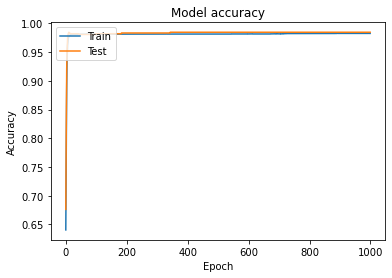

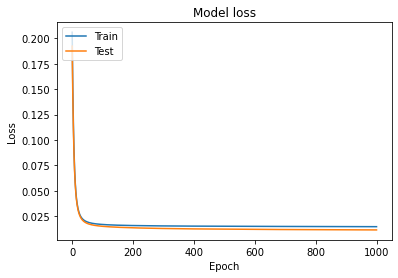

In [20]:
### VISUALISATION ###

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()